Model Building II

Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.graphics import tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose

Load daily data

In [2]:
daily_data = pd.read_csv("daily_data.csv", parse_dates=True, index_col=0)

Standardize the dataset

In [3]:
scaler = StandardScaler()
daily_data_scaled = pd.DataFrame(scaler.fit_transform(daily_data), columns=daily_data.columns, index=daily_data.index)

SARIMA

Split train and test

In [4]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-04'

daily_data_scaled.sort_index()

train = daily_data_scaled[:cutoff]
test = daily_data_scaled[cutoff:]

Diff 140

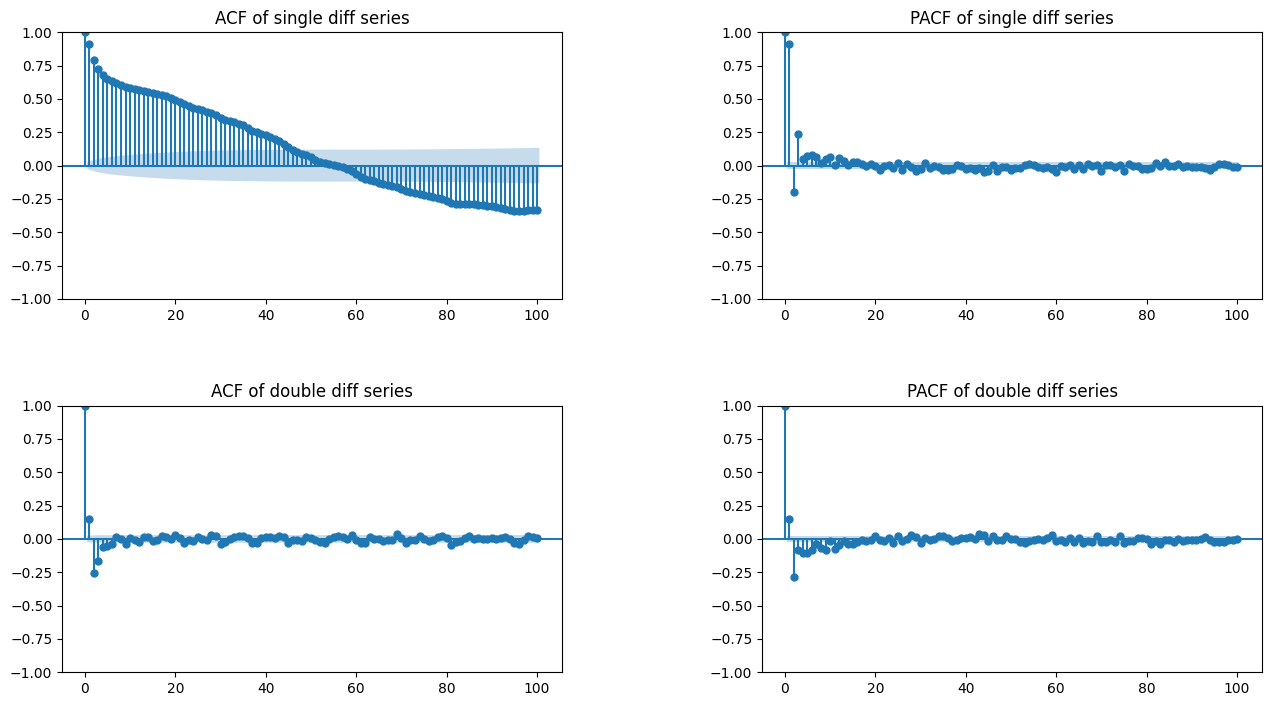

In [5]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(140).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(140).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(140).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(140).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,Q=0,P=0

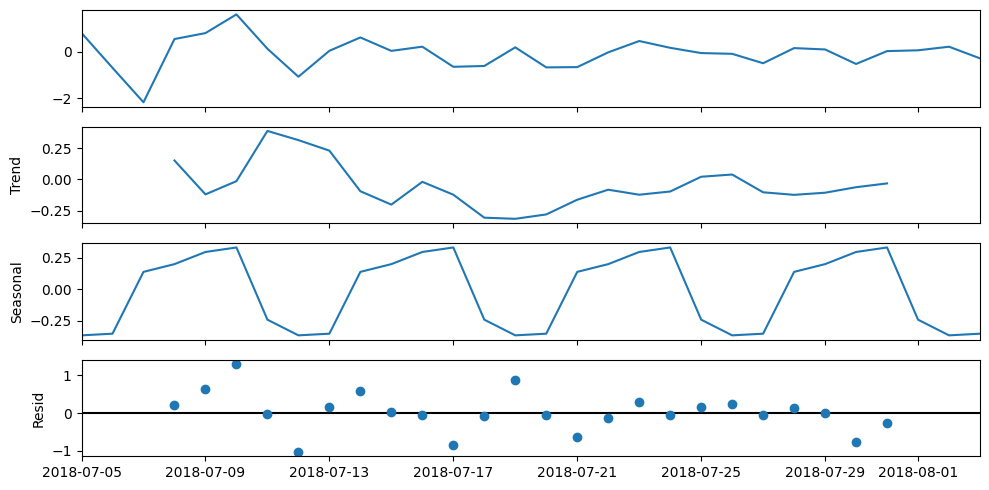

In [6]:
diff140=daily_data_scaled.diff(140).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff140[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()

In [7]:
data_3year=daily_data_scaled['2015-08-03':'2017-08-03']

In [8]:
model_140=sm.tsa.statespace.SARIMAX(data_3year,order=(2,1,3),seasonal_order=(1,1,0,140))
fitted_140 = model_140.fit(disp=-1)
print(fitted_140.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                              PJMW_MW   No. Observations:                  732
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 140)   Log Likelihood                -436.621
Date:                              Sun, 29 Jun 2025   AIC                            887.241
Time:                                      04:21:09   BIC                            917.914
Sample:                                  08-03-2015   HQIC                           899.189
                                       - 08-03-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6961      0.427      1.629      0.103      -0.141       1.534
ar.L2         -0.14

In [9]:
n_steps = 365
fc140 = fitted_140.forecast(n_steps,alpha=0.05)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Evaluate the model

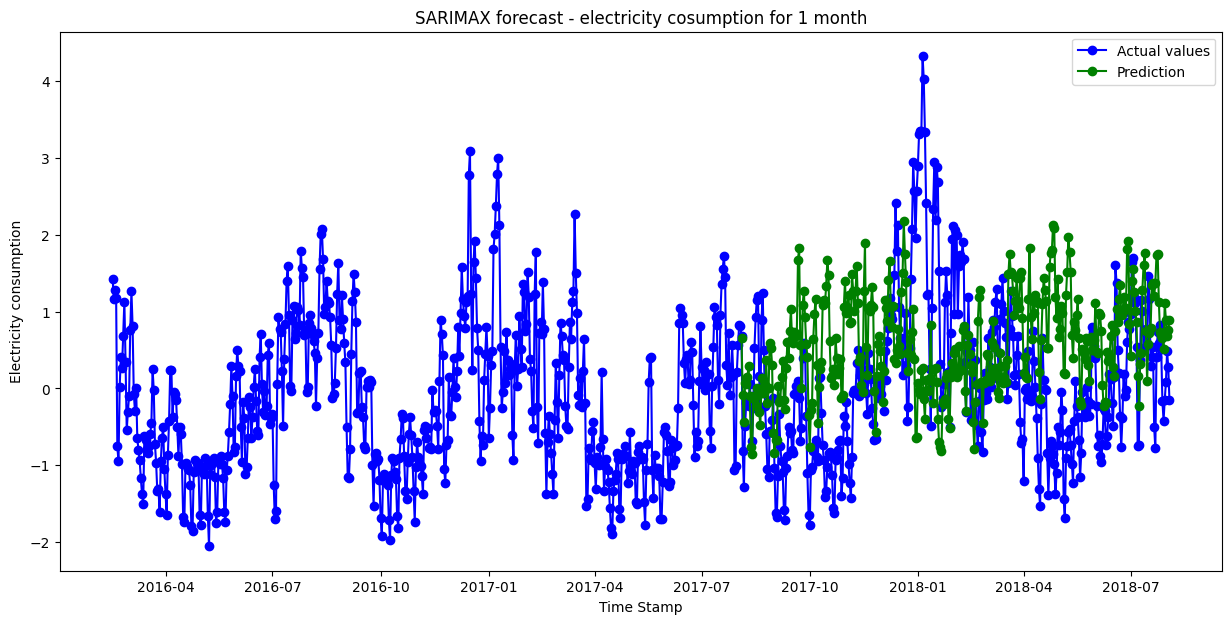

In [10]:
fitted_series140 = pd.Series(fc140,index=test.index)
fitted_series140=fitted_series140.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data_scaled[-900:].index,daily_data_scaled[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series140[-365:].index, fitted_series140[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [11]:
def mape(forecast,actual):
    mape=round(np.mean(np.abs(forecast - actual)/np.abs(actual))*100,2)
    return mape
def mae(forecast,actual):
    mae=round(np.mean(np.abs(forecast - actual)),2)
    return mae
def rmse(forecast,actual):
    rmse = round(np.mean(np.abs(forecast - actual)**2)**.5,2)
    return rmse

In [12]:
MAPE_140= mape(fitted_series140.values, test.values)
MAE_140= mae(fitted_series140.values, test.values)
print("MAPE_140: ",MAPE_140)
print("MAE_140: ",MAE_140)

MAPE_140:  480.63
MAE_140:  1.04


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_140=sqrt((mean_squared_error(fitted_series140.values,test.values)))
rmse_140

1.3032001500256916

In [22]:
daily_data_inversed = pd.DataFrame(
    scaler.inverse_transform(daily_data_scaled),
    columns=daily_data.columns,
    index=daily_data.index
)

In [23]:
daily_data_inversed

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000
...,...
2018-07-30,5492.708333
2018-07-31,5660.750000
2018-08-01,5959.708333
